## Introduction

Credit card default is a significant concern for financial institutions, as it impacts their profitability and risk management strategies. Accurately predicting which clients are likely to default can help these institutions take proactive measures to mitigate potential losses. Traditionally, supervised learning techniques have been employed for such predictive tasks. However, unsupervised learning methods offer a different perspective by uncovering hidden patterns and structures within the data without relying on predefined labels.

This project aims to assess the efficacy of various unsupervised learning techniques in predicting credit card defaults and compare their performance with traditional supervised learning methods. Using the "Default of Credit Card Clients" dataset from the UCI Machine Learning Repository, I will explore and evaluate different clustering algorithms, such as KMeans, Agglomerative Clustering, and Birch. These techniques will be contrasted with supervised learning models, including Logistic Regression, Decision Trees, and Random Forests, to determine their relative strengths and weaknesses in predicting credit card defaults.

### Dataset

The "Default of Credit Card Clients" dataset, available from the UCI Machine Learning Repository, contains information on 30,000 Taiwanese credit card holders. It includes features such as the client's demographic information, credit history, and bill payment records. The target variable indicates whether the client defaulted on their credit card payment the following month.

### Objectives

The primary objectives of this project are to preprocess the dataset, apply and evaluate unsupervised learning techniques, train and assess supervised learning models, and compare the results of these approaches to identify the most effective methods for predicting credit card defaults.

### Methodology

The methodology begins with data preprocessing, which involves cleaning and preparing the dataset to ensure its suitability for analysis. This step includes handling missing values, normalizing numerical features, and encoding categorical variables. Next, I will apply various clustering algorithms, such as KMeans, Agglomerative Clustering, and Birch, to the dataset. These unsupervised learning techniques will be evaluated using metrics such as silhouette scores to determine their ability to differentiate between defaulters and non-defaulters.

In parallel, I will train traditional supervised learning models, including Logistic Regression, Decision Trees, and Random Forests, on the dataset. These models will be evaluated using metrics like accuracy, precision, recall, F1-score, and ROC-AUC to assess their predictive performance. Finally, I will compare the results of the clustering algorithms with those of the supervised learning models. This comparison will help identify which approach provides better predictive performance and discuss the advantages and limitations of each method in the context of credit card default prediction.

### Expected Outcomes

This project will provide insights into the applicability of unsupervised learning techniques for predicting credit card defaults. By comparing these methods with traditional supervised learning models, I aim to identify potential advantages of clustering algorithms in uncovering underlying patterns that may not be captured by supervised approaches. The findings might contribute to a better understanding of how different machine learning techniques can be leveraged for credit risk assessment aiding financial institutions in improving their risk management strategies.

I don't have any specific factors that I believe will be more important than others prior to analysis.  However, at the end of this analysis I will offer a feature importance with SHAP library to determine which features offer the most predicitve power under my supervised learning models trained.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.cluster import AgglomerativeClustering, Birch, KMeans
from scipy.stats import zscore, mode
import shap
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

/home/bbehe/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
###Fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

First 5 rows of the dataset:
       X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...    X15    X16    X17  \
0   20000   2   2   1  24   2   2  -1  -1   -2  ...      0      0      0   
1  120000   2   2   2  26  -1   2   0   0    0  ...   3272   3455   3261   
2   90000   2   2   2  34   0   0   0   0    0  ...  14331  14948  15549   
3   50000   2   2   1  37   0   0   0   0    0  ...  28314  28959  29547   
4   50000   1   2   1  57  -1   0  -1   0    0  ...  20940  19146  19131   

    X18    X19    X20   X21   X22   X23  Default  
0     0    689      0     0     0     0        1  
1     0   1000   1000  1000     0  2000        1  
2  1518   1500   1000  1000  1000  5000        0  
3  2000   2019   1200  1100  1069  1000        0  
4  2000  36681  10000  9000   689   679        0  

[5 rows x 24 columns]

Summary Statistics:
                   X1            X2            X3            X4            X5  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
me

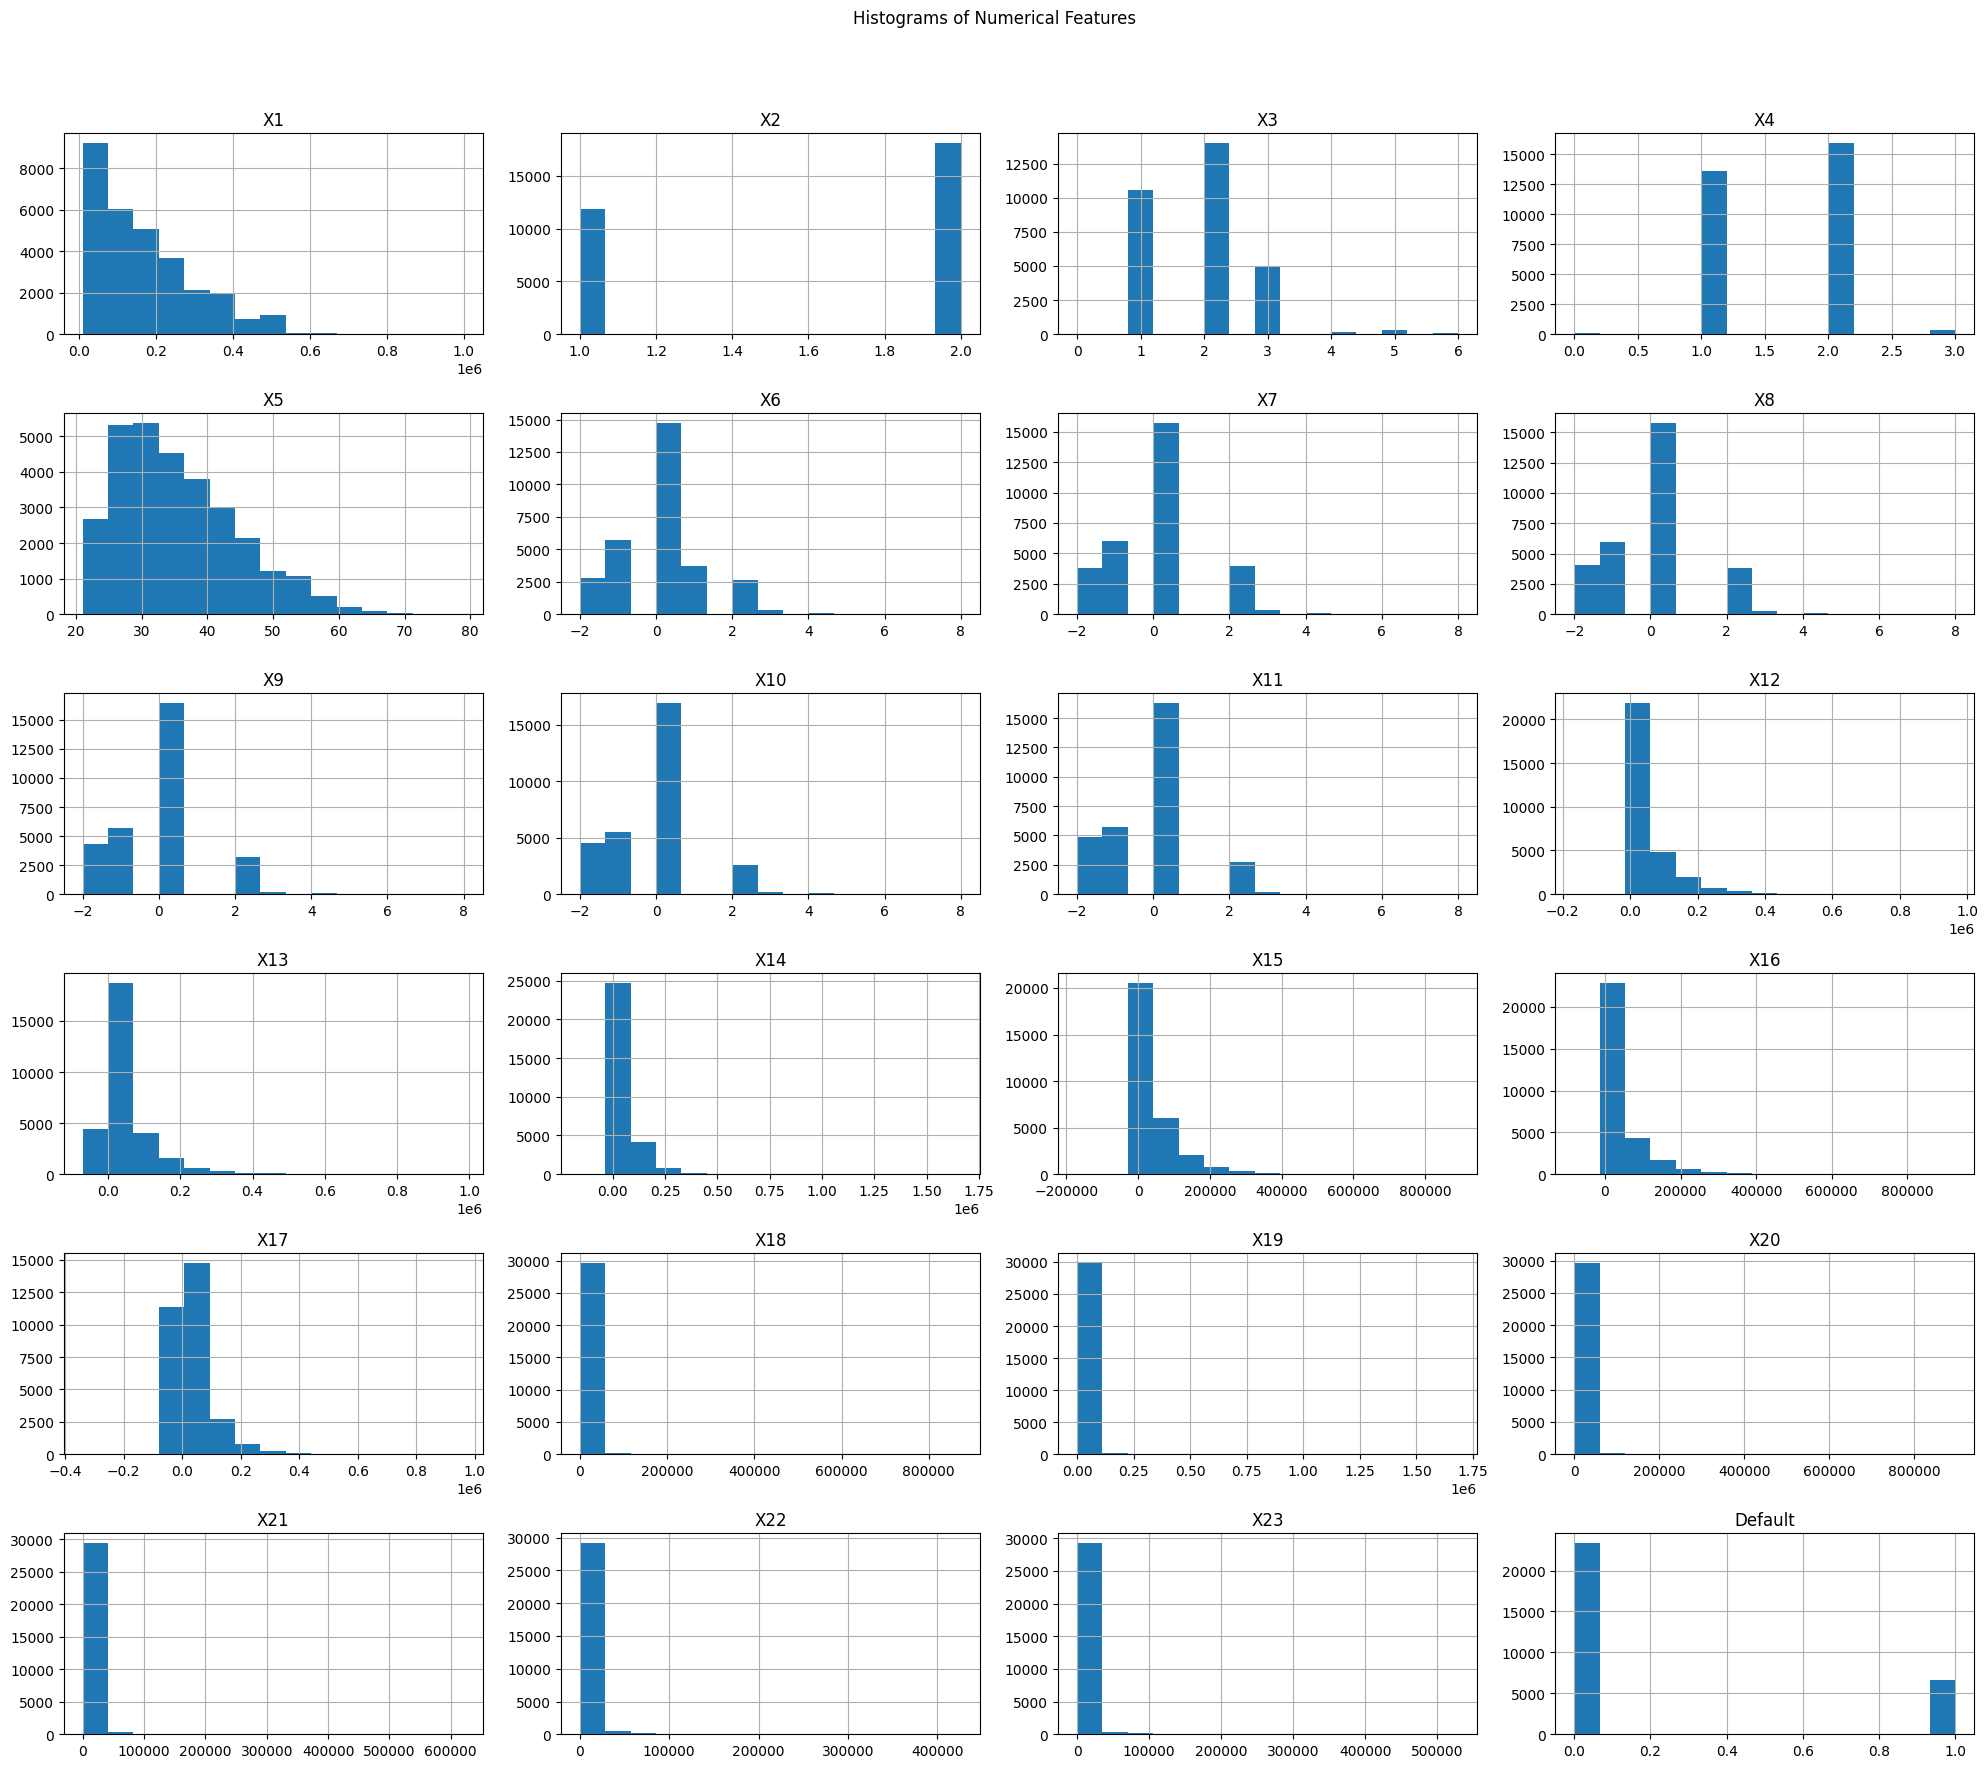

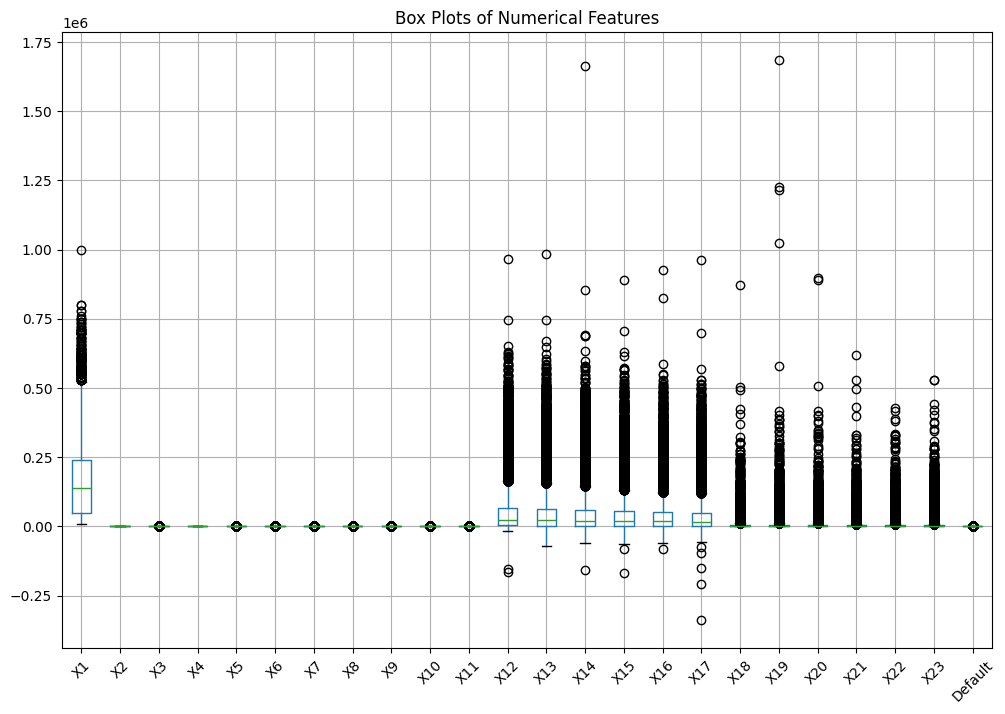

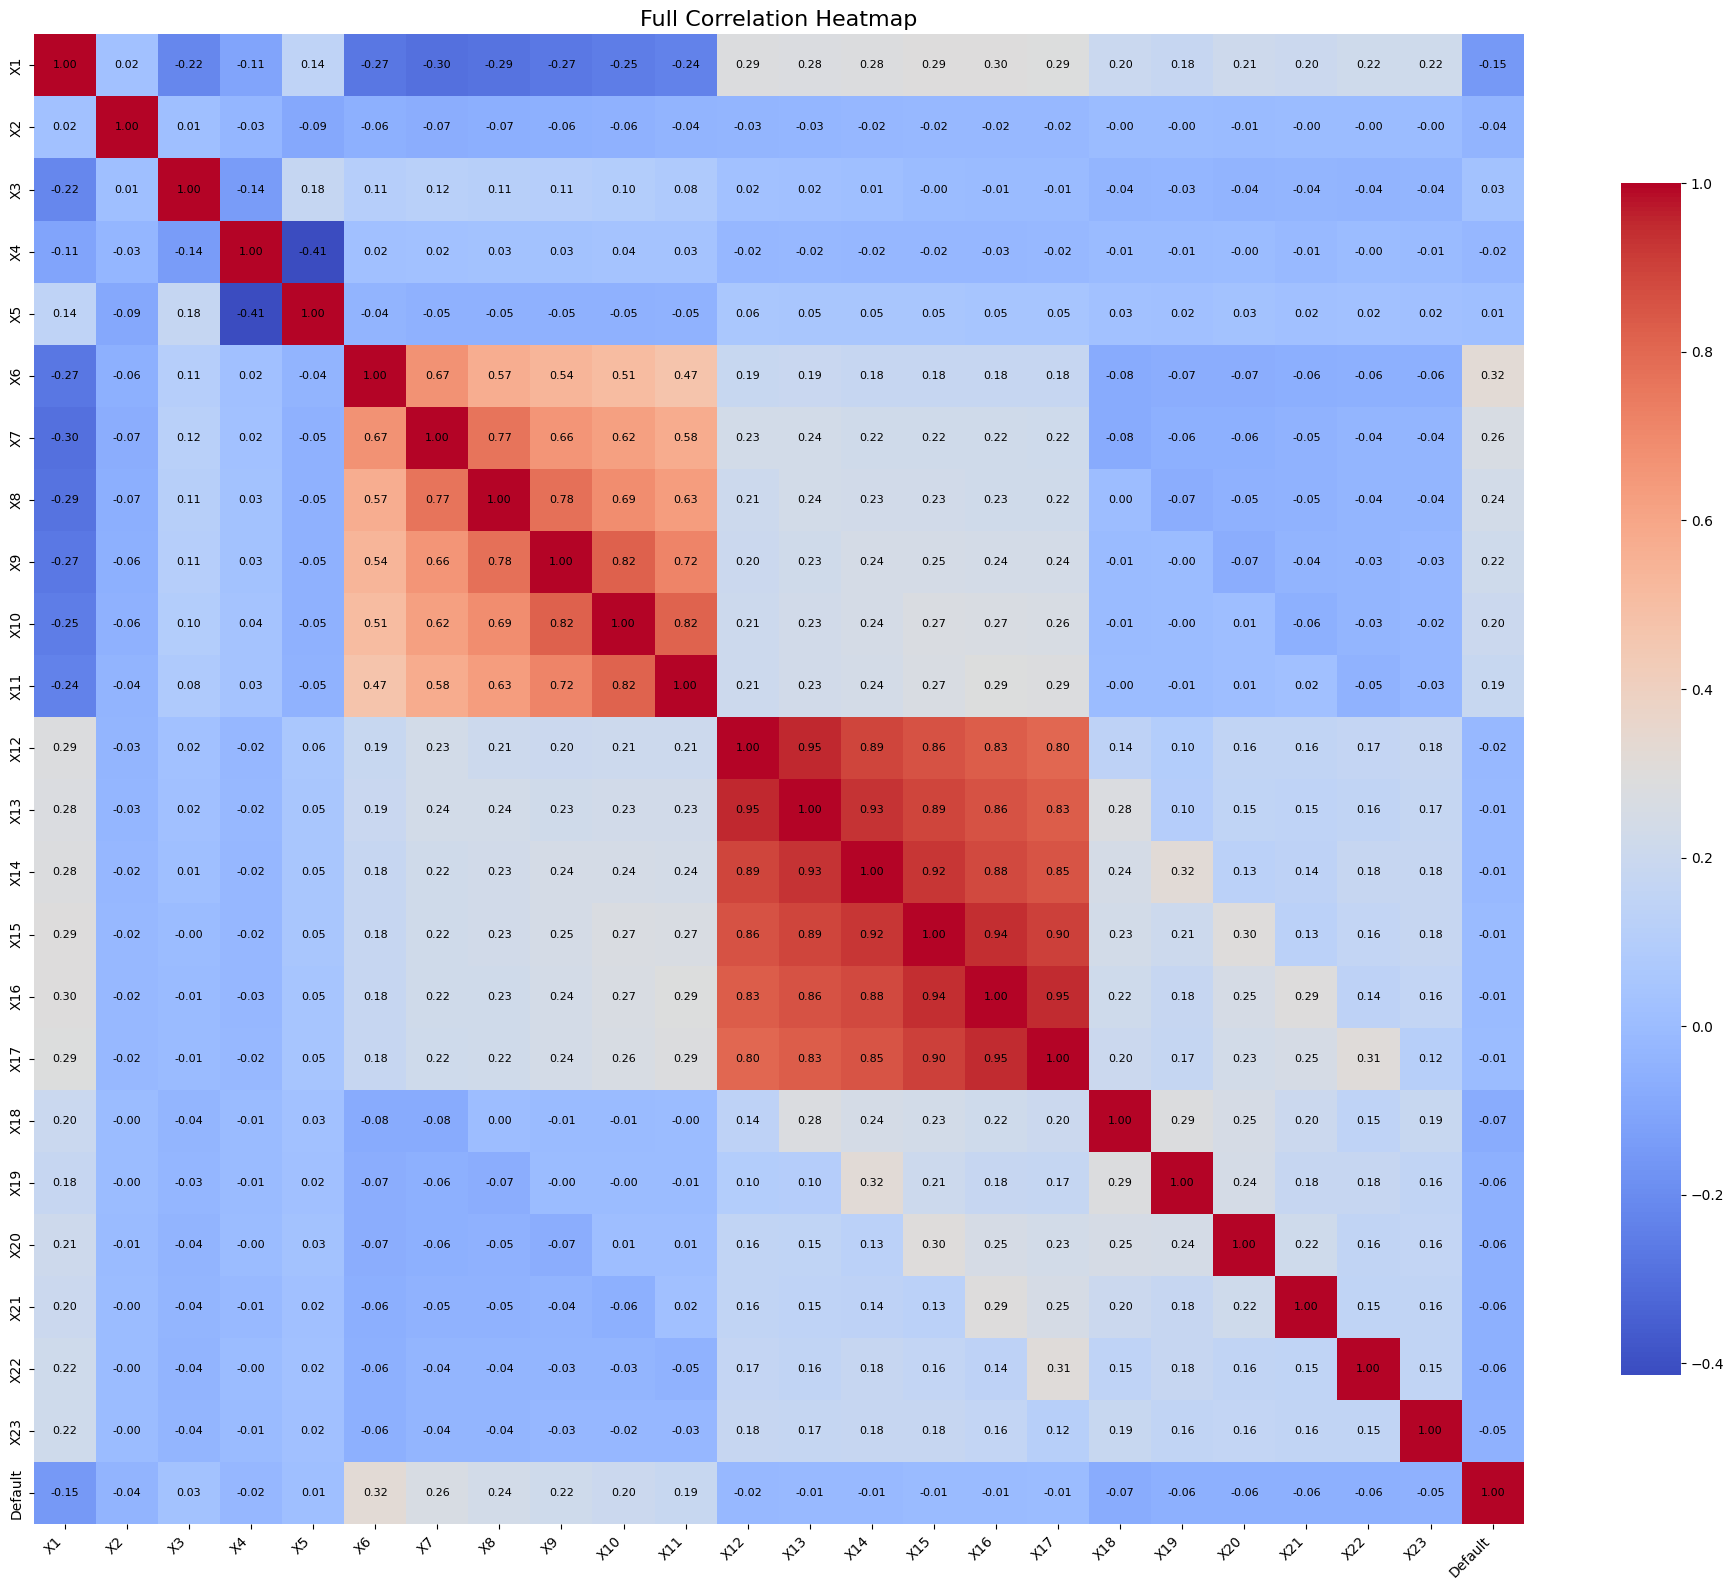

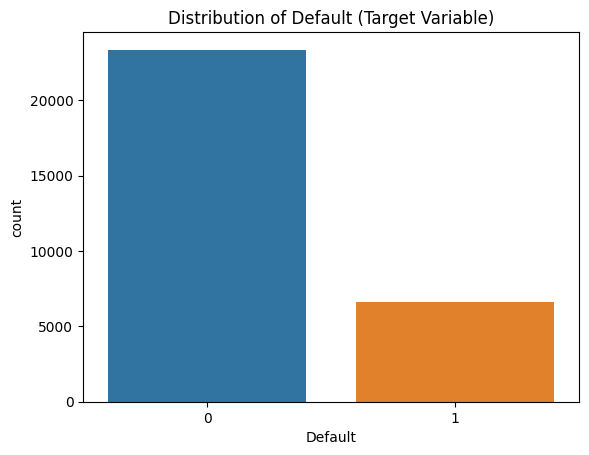

In [3]:
def perform_eda(X, y):
    ###Merge features and target into a single DataFrame for analysis
    data = X.copy()
    data['Default'] = y

    ###Display the first few rows of the dataset
    print("First 5 rows of the dataset:")
    print(data.head())

    ###Summary statistics
    print("\nSummary Statistics:")
    print(data.describe())

    ###Missing values
    print("\nMissing Values:")
    print(data.isnull().sum())

    ###Data types
    print("\nData Types:")
    print(data.dtypes)

    ###Generate visualizations
    ###Visualization 1: Histograms of numerical features
    num_cols = data.select_dtypes(include=np.number).columns.tolist()
    if len(num_cols) > 0:
        n_rows = (len(num_cols) + 3) // 4  
        data[num_cols].hist(bins=15, figsize=(20, n_rows * 3), layout=(n_rows, 4))
        plt.suptitle('Histograms of Numerical Features')
        plt.tight_layout(rect=[0, 0, 1, 0.95])  
        plt.show()

    ###Visualization 2: Box plots for numerical features to spot outliers
    plt.figure(figsize=(12, 8))
    data[num_cols].boxplot()
    plt.title('Box Plots of Numerical Features')
    plt.xticks(rotation=45)
    plt.show()

    ###Visualization 3: Correlation heatmap
    ###Calculate correlation matrix
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(20, 16))
    heatmap = sns.heatmap(corr, square=True, cmap='coolwarm', cbar_kws={"shrink": .8}, ax=ax)

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j + 0.5, i + 0.5, format(corr.iloc[i, j], '.2f'), 
                    horizontalalignment='center', verticalalignment='center', 
                    color="black", fontsize=8)

    ax.set_xticks(np.arange(len(corr.columns)) + 0.5)
    ax.set_yticks(np.arange(len(corr.columns)) + 0.5)
    ax.set_xticklabels(corr.columns, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(corr.columns, fontsize=10)

    plt.title('Full Correlation Heatmap', fontsize=16)
    plt.tight_layout()  
    plt.show()

    ###Visualization 4: Countplot for the target variable
    sns.countplot(x='Default', data=data)
    plt.title('Distribution of Default (Target Variable)')
    plt.show()

###Perform EDA!! 
perform_eda(X, y)


# Variable Information for Default of Credit Card Clients Dataset

| **Variable** | **Description**                                                                                                                                                                          |
|--------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| X1           | Amount of the given credit (NT dollar): includes both individual consumer credit and family (supplementary) credit.                                                                      |
| X2           | Gender (1 = male; 2 = female).                                                                                                                                                           |
| X3           | Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).                                                                                                            |
| X4           | Marital status (1 = married; 2 = single; 3 = others).                                                                                                                                    |
| X5           | Age (year).                                                                                                                                                                              |
| X6           | History of past payment in September, 2005 (-1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = nine months+). |
| X7           | History of past payment in August, 2005 (-1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = nine months+).   |
| X8           | History of past payment in July, 2005 (-1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = nine months+).     |
| X9           | History of past payment in June, 2005 (-1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = nine months+).     |
| X10          | History of past payment in May, 2005 (-1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = nine months+).      |
| X11          | History of past payment in April, 2005 (-1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = nine months+).    |
| X12          | Amount of bill statement in September, 2005 (NT dollar).                                                                                                                                 |
| X13          | Amount of bill statement in August, 2005 (NT dollar).                                                                                                                                    |
| X14          | Amount of bill statement in July, 2005 (NT dollar).                                                                                                                                      |
| X15          | Amount of bill statement in June, 2005 (NT dollar).                                                                                                                                      |
| X16          | Amount of bill statement in May, 2005 (NT dollar).                                                                                                                                       |
| X17          | Amount of bill statement in April, 2005 (NT dollar).                                                                                                                                     |
| X18          | Amount paid in September, 2005 (NT dollar).                                                                                                                                              |
| X19          | Amount paid in August, 2005 (NT dollar).                                                                                                                                                 |
| X20          | Amount paid in July, 2005 (NT dollar).                                                                                                                                                   |
| X21          | Amount paid in June, 2005 (NT dollar).                                                                                                                                                   |
| X22          | Amount paid in May, 2005 (NT dollar).                                                                                                                                                    |
| X23          | Amount paid in April, 2005 (NT dollar).                                                                                                                                                  |
| Y            | Default payment (Yes = 1, No = 0).                                                                                                                                                       |


This table concisely summarizes the relationships between the features as observed from the correlation matrix.

| Feature | Correlations                                                                                                          |
|---------|-----------------------------------------------------------------------------------------------------------------------|
| **X1**  | Moderate positive correlation with X12 (0.29), X13 (0.28), X14 (0.28), X15 (0.29), and X16 (0.30).                     |
| **X2**  | Very low correlations with all other features, indicating relative independence.                                      |
| **X3**  | Moderate negative correlation with X4 (-0.14), positive correlation with X5 (0.18), very low correlations with others.|
| **X4**  | Strong negative correlation with X5 (-0.41), negligible correlations with other features.                             |
| **X5**  | Moderate negative correlation with X4 (-0.41), very low correlations with other features.                             |
| **X6**  | Very strong positive correlation with X7 (0.67), moderate positive correlations with X8 (0.57), X9 (0.54), X10 (0.51).|
| **X7**  | Strong positive correlation with X6 (0.67) and X8 (0.77), moderate correlations with X9 (0.66), X10 (0.62).           |
| **X8**  | Strong correlation with X7 (0.77) and X9 (0.78), moderate correlations with X6 (0.57) and X10 (0.69).                 |
| **X9**  | Strong positive correlations with X8 (0.78) and X10 (0.82), moderate correlations with X7 (0.66), X6 (0.54).          |
| **X10** | Strong positive correlation with X9 (0.82), moderate correlations with X8 (0.69), X7 (0.62), X6 (0.51).               |
| **X11** | Strong positive correlations with X10 (0.82) and X9 (0.72), moderate correlations with X8 (0.63), X7 (0.58).          |
| **X12** | Very high correlation with X13 (0.93), X14 (0.89), X15 (0.86), X16 (0.83).                                            |
| **X13** | Very strong correlation with X12 (0.93), X14 (0.89), X15 (0.89), X16 (0.86).                                          |
| **X14** | High correlations with X12 (0.89), X13 (0.89), X15 (0.92), X16 (0.88).                                                |
| **X15** | Very strong correlation with X14 (0.92), X12 (0.86), X13 (0.89), X16 (0.94).                                          |
| **X16** | Very strong correlations with X15 (0.94), X14 (0.88), X13 (0.86), X12 (0.83).                                         |
| **X17** | High correlations with X16 (0.95), X15 (0.90), X14 (0.85), X12 (0.80).                                                |
| **X18** | Moderate correlations with X19 (0.29), X15 (0.24), X14 (0.24), low correlations with others.                          |
| **X19** | Moderate correlations with X18 (0.29), low correlations with other features.                                          |
| **X20** | Low to moderate correlations with all other features, highest with X15 (0.30).                                        |
| **X21** | Low correlations with other features, indicating relative independence.                                               |
| **X22** | Low correlations with other features, indicating relative independence.                                               |
| **X23** | Low correlations with other features, indicating relative independence.                                               |


Here's the description of the data distributions


| Feature  | Description                                                                                                  |
|----------|--------------------------------------------------------------------------------------------------------------|
| X1       | Right-skewed, with the majority of data points concentrated towards the lower end of the range.              |
| X2       | Bimodal distribution, with two distinct peaks suggesting two subgroups within the data.                      |
| X3       | Multimodal distribution with several peaks.                       |
| X4       | Very clear bimodal distribution, indicating two primary value ranges that are prominent.                     |
| X5       | Roughly normal distribution, with a single peak and values symmetrically distributed around the mean.        |
| X6       | Multimodal distribution with several peaks, indicating multiple subgroups or clusters within the data.       |
| X7       | Multimodal distribution with several peaks, similar to X6.                                                   |
| X8       | Multimodal distribution with multiple peaks, indicating the presence of several distinct groups.             |
| X9       | Multimodal distribution with multiple peaks, similar to X8.                                                  |
| X10      | Multimodal distribution with multiple peaks, similar to X6, X7, and X8.                                      |
| X11      | Multimodal distribution with multiple peaks, similar to X6, X7, X8, and X9.                                  |
| X12      | Right-skewed, with most values clustered at the lower end of the range, similar to X1.                       |
| X13      | Right-skewed, with a concentration of data points towards the lower end of the range.                        |
| X14      | Right-skewed distribution, similar to X1, X12, and X13.                                                      |
| X15      | Right-skewed, with most values clustered at the lower end of the range, similar to X1, X12, X13, and X14.    |
| X16      | Right-skewed distribution, with a majority of the values towards the lower end, similar to X1, X12, and X15. |
| X17      | Right-skewed distribution, with most values concentrated at the lower end, similar to X1, X12, and X16.      |
| X18      | Right-skewed, with most values clustered at the lower end, similar to the previously mentioned features.     |
| X19      | Right-skewed distribution, with the majority of values at the lower end, resembling X1, X12, and X18.        |
| X20      | Right-skewed, with most values concentrated at the lower end, similar to X1, X12, and X19.                   |
| X21      | Right-skewed distribution, with most values at the lower end, similar to the majority of the other features. |
| X22      | Right-skewed distribution, with most values clustered at the lower end, resembling the other features.       |
| X23      | Right-skewed, with most values at the lower end, similar to the other features.                              |
| Default  | Binary target variable, indicating a classification problem. Shows a class imbalance with more 0s than 1s.   |


Below I de-skew right skewed distributions using a log transformation

In [ ]:
###Combine features and target into one DataFrame for transformations
df = X.copy()
df['Default'] = y

###Log transform for right-skewed features
right_skewed_features = ['X1', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
for feature in right_skewed_features:
    df[feature] = np.log1p(df[feature])

###Power transform for left-skewed features
#left_skewed_features = ['X3']
#for feature in left_skewed_features:
#    df[feature] = np.cbrt(df[feature])

###Replace -inf and inf values with NaN and then drop them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

###Check the shape of the DataFrame after transformations and NaN removal
print("Shape of DataFrame after transformations and NaN removal:", df.shape)

###Separate features and target
X_transformed = df.drop(columns=['Default'])
y_filtered = df['Default']

## Data Preprocessing Summary

This section describes the preprocessing steps applied to the "Default of Credit Card Clients" dataset, resulting in a final dataframe with dimensions (24966, 17).

### Feature Transformation

The dataset initially contained a mix of categorical, ordinal, and numeric features. The categorical features, including Gender (X2), Education (X3), and Marital Status (X4), were one-hot encoded to convert them into a numerical format suitable for machine learning algorithms. One-hot encoding was applied with the drop='first' parameter to avoid multicollinearity by dropping the first category. The ordinal features, specifically the History of past payments (X6-X11), were treated as ordinal features, preserving their numeric format. All other features (X1, X5, X12-X23), which were numeric, were standardized using the StandardScaler to ensure they have a mean of 0 and a standard deviation of 1.

### Missing Values

There were no missing values noted in the dataset.  However, after transformation, there were obsservations that needed to be dropped due to -inf values being introduced.  If data had been missing from the start, I would have tested (just like my hyperparemeter searches below) appropriate strategies like imputation via median, mode, and model classification.


### Removal of Highly Correlated Features

Highly correlated features can introduce redundancy and multicollinearity in the dataset, negatively impacting the performance of machine learning models. To address this, the correlation matrix of the features was calculated, and features with a correlation coefficient above 0.9 were identified. One of each pair of highly correlated features was removed.

### Outlier Detection and Removal

Outliers can skew the results of machine learning models and lead to poor generalization on unseen data. To mitigate this, z-scores for each feature in the dataset were calculated, and observations with any feature having a z-score greater than 3 (values more than three standard deviations away from the mean) were filtered out. This process helped in removing extreme outliers from the dataset.

### Final Data Frame

After transforming categorical features, removing outliers, and eliminating highly correlated variables, the resulting dataframe contains 26,268 observations and 25 features. This preprocessing ensures that the dataset is well-prepared for machine learning algorithms, reducing redundancy and mitigating the influence of outliers, thereby improving model performance and interpretability.

### Scaling the Features

To ensure our features are on a similar scale and improve the performance of our models, we standardized the data using the StandardScaler. This scaler adjusts the data so that each feature has a mean of 0 and a standard deviation of 1. We first fit the scaler on the training data and transformed it accordingly. Then, we applied the same scaling to the validation and test sets, maintaining consistency across all data subsets. This consistency is crucial for making sure the models trained on the scaled training data can accurately interpret and generalize to the validation and test data.

### Dimensionality Reduction Using PCA

To further enhance the dataset and reduce its dimensionality, we applied Principal Component Analysis (PCA). PCA is a technique that transforms the original features into a new set of features called principal components, which are uncorrelated and ordered by the amount of variance they explain in the data. By retaining 95% of the variance, PCA helps in capturing the most important aspects of the data while reducing the number of features. This step not only helps in mitigating the curse of dimensionality but also improves the efficiency of subsequent machine learning algorithms by reducing computational complexity and potentially enhancing model performance.

In [5]:
X = X_transformed.copy()
y = y_filtered.copy()

###Define the categorical features
categorical_features = ['X2', 'X3', 'X4']
ordinal_features = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11']
numeric_features = ['X1', 'X5'] + ['X12', 'X13', 'X14', 'X15', 'X16', 'X17'] + ['X18', 'X19', 'X20', 'X21', 'X22', 'X23']

###Combine all features for initial analysis
all_features = categorical_features + ordinal_features + numeric_features
X_all = X[all_features]

###One-hot encode categorical features for initial analysis
one_hot_encoder = OneHotEncoder(drop='first')
X_cat_encoded = one_hot_encoder.fit_transform(X[categorical_features]).toarray()

###Create DataFrame with encoded categorical features
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)
X_encoded_df = pd.DataFrame(X_cat_encoded, columns=encoded_feature_names, index=X.index)

###Combine encoded categorical features with ordinal and numeric features
X_combined = pd.concat([X_encoded_df, X[ordinal_features], X[numeric_features]], axis=1)

###Remove highly correlated columns
corr_matrix = X_combined.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
X_combined = X_combined.drop(columns=to_drop)

###Identify and remove extreme outliers
z_scores = np.abs(zscore(X_combined))
filtered_entries = (z_scores < 3).all(axis=1)
X_filtered = X_combined[filtered_entries]

###Filter the target variable to match the filtered features
y_filtered = y[filtered_entries]

###Define the remaining numeric and categorical features
remaining_numeric_features = [feature for feature in numeric_features if feature not in to_drop]
remaining_categorical_features = [feature for feature in encoded_feature_names if feature not in to_drop]
remaining_features = remaining_categorical_features + ordinal_features + remaining_numeric_features

###Preprocessing pipeline for the filtered data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), remaining_numeric_features),
        ('cat', 'passthrough', remaining_categorical_features),
        ('ord', 'passthrough', ordinal_features)
    ]
)


###Fit and transform the filtered data
X_transformed = preprocessor.fit_transform(X_filtered)

###Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_transformed)

###Convert the PCA-transformed data back to a DataFrame
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

###Combine PCA-transformed features with the target
final_df = pd.concat([X_pca_df.reset_index(drop=True), y_filtered.reset_index(drop=True)], axis=1)

print(final_df.head())
final_df.shape

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.861203  4.325046 -0.844705 -0.204869  0.986500  3.576721 -0.690180   
1  0.788910  2.241960  1.897169 -1.677734 -0.817945  0.750874  0.172805   
2 -0.532213 -0.092472  0.163271 -0.379078  0.046212 -0.073511  0.156917   
3 -1.043633 -0.034157 -0.194174  0.095077 -0.387849 -0.058636 -0.216325   
4 -0.352126 -1.211694  0.853686  1.338296 -2.463645 -0.118260 -0.478253   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  1.353053 -0.611896  0.724695 -0.261489 -0.159038  1.298143 -0.739392   
1 -0.382701  2.344968  0.677383 -0.218331 -0.952302 -0.765099 -1.849759   
2  0.130916 -0.120215  0.575317  0.333227 -0.435118  0.035593  0.047387   
3  0.734741 -0.364992  0.313690  0.473621 -0.447689 -0.124527 -0.039276   
4  1.081170 -0.170721  0.152022 -0.126579 -0.327655 -0.028313 -0.374372   

       PC15      PC16  Default  
0 -0.616987  0.012820        1  
1 -0.254684 -0.144139        1  

(24966, 17)

SMOTE is a popular technique used to address class imbalance in datasets.  SMOTE works by creating synthetic samples for the minority class. It does this by selecting a random sample from the minority class and finding its k-nearest neighbors.  Below I tested SMOTE'ing the data set to see if it would affect the performance.

In [6]:
features = final_df.drop(columns=["Default"])
labels = y_filtered
''' ###Uncomment to run Smote!
# Implement SMOTE to balance the dataset
smote = SMOTE(random_state=42)
features, labels = smote.fit_resample(features, labels)

# Check the shape of the balanced data
print("Shape of features after SMOTE:", features.shape)
print("Distribution of target after SMOTE:", labels.value_counts())'''

'\n# Implement SMOTE to balance the dataset\nsmote = SMOTE(random_state=42)\nfeatures, labels = smote.fit_resample(features, labels)\n\n# Check the shape of the balanced data\nprint("Shape of features after SMOTE:", features.shape)\nprint("Distribution of target after SMOTE:", labels.value_counts())'

### Splitting Data into Training, Validation, and Test Sets

To properly train, tune, and evaluate our machine learning models, we divided the dataset into three parts: training, validation, and test sets. First, we assigned 70% of the data to the training set, which is used to teach the models by letting them learn patterns from the data. The remaining 30% was then split evenly into two parts creating a validation set and a test set each comprising 15% of the original dataset.

The validation set is essential during the training process because it helps us fine-tune the model’s hyperparameters and evaluate its performance. After tuning, we use the test set to evaluate the model’s final performance. This set provides an unbiased assessment of how well the model generalizes to entirely new data.

In [ ]:
###Splitting data into training, validation, and test sets
train_features, remaining_features, train_labels, remaining_labels = train_test_split(features, labels, test_size=0.3, random_state=42)
validation_features, test_features, validation_labels, test_labels = train_test_split(remaining_features, remaining_labels, test_size=0.5, random_state=42)

train_features_scaled = train_features 
validation_features_scaled = validation_features
test_features_scaled = test_features

### Hyperparameter Tuning and Cluster Evaluation

Hyperparameter tuning is a crucial step in training machine learning models. For my Random Forest and XGBoost classifiers, I adjusted hyperparameters such as the number of trees (estimators), the maximum depth of each tree, the minimum number of samples required to split a node, and the minimum number of samples required at a leaf node. For Logistic Regression, I tuned the penalty type, regularization strength (C), solver type, and the number of iterations. I used grid search with cross-validation to systematically explore different combinations of these hyperparameters, allowing me to find the best set of parameters that resulted in the highest performance on the validation set.

I also used the Silhouette Score to evaluate my clustering efforts. The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, with higher values indicating better matching within clusters and poorer matching with neighboring clusters. By using the Silhouette Score, I could determine the optimal number of clusters that provided the best separation and cohesion among data points.

Admittedly, using the Silhouette Score to evaluate clustering performance given existing labels is somewhat unusual. Typically, this score is used in purely unsupervised learning scenarios to evaluate clustering quality. However, there are several advantages to this approach. Firstly, clustering helps uncover natural groupings within the data that might not be immediately apparent. This can provide valuable insights into the underlying patterns and distributions in the dataset. Secondly, identifying the best clusters gives me a baseline for unsupervised learning methods, which I can then compare to the performance of supervised learning models. This highlights the benefits of having labeled data. Thirdly, clustering helps me understand the structure and complexity of the data. By comparing the identified clusters with actual labels, I can see how well the natural groupings align with the labeled outcomes. 

The three clustering algorithms utilized in this analysis in KMeans, Agglomerative Clustering, and BIRCH are well-regarded methods in unsupervised machine learning each with distinct characteristics, hyperparameters, strengths, and weaknesses.

### KMeans Clustering

KMeans clustering is a partitioning method that aims to divide the dataset into kk clusters, where each cluster is represented by its centroid. The primary hyperparameters of KMeans include n_clusters, which denotes the number of clusters (in this case, set to 2-3). This parameter is critical as it directly influences the algorithm’s output. The init_options parameter determines the method for initializing the centroids, with options including 'k-means++' (which spreads out the initial centroids to be distant from each other) and 'random' (randomly selects initial centroids). Additionally, n_init_options specifies the number of times the algorithm will run with different centroid seeds (here, set to 10 and 20) and returns the best output in terms of inertia (sum of squared distances from each point to its assigned centroid) [1].

KMeans is computationally efficient and works well when clusters are roughly spherical and equally sized. It is simple to understand and implement. However, it struggles with clusters of different shapes and densities and is sensitive to the initial placement of centroids, potentially leading to different results on different runs [1].

### Agglomerative Clustering

Agglomerative Clustering is a type of hierarchical clustering that builds nested clusters by repeatedly merging or splitting them. The relevant hyperparameters include n_clusters, which sets the number of clusters to form (here, 2-3), and linkage, which defines the strategy to merge clusters. The linkage options include ward (minimizes the variance within each cluster), complete (maximizes the distance between clusters), average (uses the average of the distances between all pairs of samples), and single (minimizes the minimum distance between clusters) [2].

Agglomerative Clustering does not require the number of clusters to be specified initially and can capture complex relationships in the data. It is also less sensitive to the initial choice of parameters. However, it is computationally expensive, especially for large datasets, and choosing the right linkage criterion can be challenging. It also has difficulty scaling to very large datasets [2].

### BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

BIRCH is a hierarchical clustering algorithm designed to handle large datasets efficiently. It incrementally constructs a clustering feature (CF) tree, a compact summary of the data, and then performs clustering. Key hyperparameters include n_clusters, which specifies the number of clusters (set to 2-3), and threshold, which determines the radius of the sub-clusters (or the CF tree nodes). The threshold influences the granularity of the intermediate clusters and can range from 0.1 to 1.0 in this case [3].

BIRCH is efficient and scalable, able to handle large datasets by creating a compact representation of the data. It can adaptively find the appropriate number of clusters if the threshold is set correctly. However, it may not perform well with datasets that contain clusters of varying densities or sizes. The choice of threshold is crucial; a poorly chosen threshold can significantly impact the performance and results [3].

### References

    1. Jain, A.K. (2010). Data clustering: 50 years beyond K-means. Pattern Recognition Letters, 31(8), 651-666.
    2. Xu, R., & Wunsch, D. (2005). Survey of clustering algorithms. IEEE Transactions on Neural Networks, 16(3), 645-678.
    3. Zhang, T., Ramakrishnan, R., & Livny, M. (1996). BIRCH: An efficient data clustering method for very large databases. In ACM SIGMOD Record (Vol. 25, No. 2, pp. 103-114).
    4. Han, J., Kamber, M., & Pei, J. (2011). Data Mining: Concepts and Techniques. Elsevier.

KMeans(n_clusters=2, n_init=10)   k-means++   10
KMeans(n_clusters=2, n_init=20)   k-means++   20
KMeans(init='random', n_clusters=2, n_init=10)   random   10
KMeans(init='random', n_clusters=2, n_init=20)   random   20
KMeans(n_clusters=2, n_init=10)   k-means++   10
KMeans(n_clusters=2, n_init=20)   k-means++   20
KMeans(init='random', n_clusters=2, n_init=10)   random   10
KMeans(init='random', n_clusters=2, n_init=20)   random   20
Accuracy on test data for KMeans (combined model): 0.789853137516689
Precision on test data for KMeans (combined model): 0.3949265687583445
Recall on test data for KMeans (combined model): 0.5
Accuracy on test data for KMeans (train model): 0.789853137516689
Precision on test data for KMeans (train model): 0.3949265687583445
Recall on test data for KMeans (train model): 0.5
AgglomerativeClustering()   2   ward
AgglomerativeClustering(linkage='complete')   2   complete
AgglomerativeClustering(linkage='average')   2   average
AgglomerativeClustering(linkag

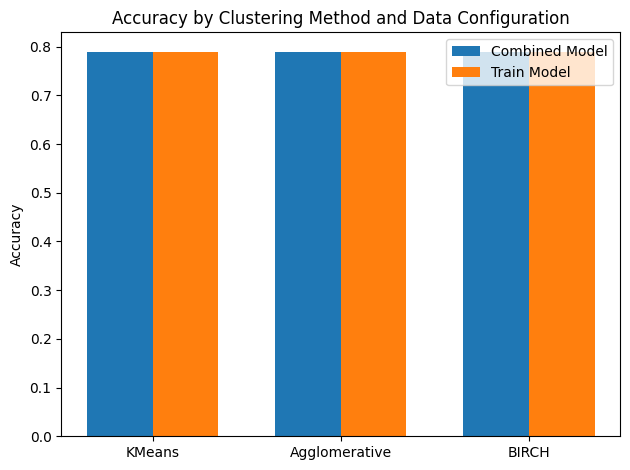

In [8]:
###Combine training and validation sets
X_train_val = np.vstack((train_features_scaled, validation_features_scaled))
y_train_val = np.concatenate((train_labels, validation_labels))

###Define clustering algorithms with their hyperparameter ranges
algorithms = {
    'KMeans': {
        'model': KMeans(),
        'params': {
            'n_clusters': range(2, 11),
            'init_options': ['k-means++', 'random'],
            'n_init_options': [10, 20]
        }
    },
    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'params': {
            'n_clusters': range(2, 11),
            'linkage': ['ward', 'complete', 'average', 'single']
        }
    },
    'BIRCH': {
        'model': Birch(),
        'params': {
            'n_clusters': range(2, 11),
            'threshold': [0.1, 0.3, 0.5, 0.7, 1.0]
        }
    }
}

###Function to perform clustering, evaluate silhouette score on a validation data
def evaluate_clustering(model, params, X_train, X_val):
    best_score = -1
    best_model = None
    for n_clusters in params.get('n_clusters', [None]):
        if 'linkage' in params:
            for linkage in params['linkage']:
                model.set_params(n_clusters=n_clusters, linkage=linkage)
                print(model, " ", n_clusters, " ", linkage)
                model.fit(X_train)
                labels = model.fit_predict(X_val)
                score = silhouette_score(X_val, labels)
                if score > best_score:
                    best_score = score
                    best_model = model.__class__(n_clusters=n_clusters, linkage=linkage)
        elif 'threshold' in params:
            for threshold in params['threshold']:
                
                model.set_params(n_clusters=n_clusters, threshold=threshold)
                print(model, " ", n_clusters, " ", threshold)
                model.fit(X_train)
                labels = model.predict(X_val)
                score = silhouette_score(X_val, labels)
                if score > best_score:
                    best_score = score
                    best_model = model.__class__(n_clusters=n_clusters, threshold=threshold)
        else:
            for init in params.get('init_options', ['k-means++']):
                for n_init in params.get('n_init_options', [10]):
                    model.set_params(n_clusters=n_clusters, n_init=n_init, init=init)
                    print(model, " ", init, " ", n_init)
                    model.fit(X_train)
                    labels = model.predict(X_val)
                    score = silhouette_score(X_val, labels)
                    if score > best_score:
                        best_score = score
                        best_model = model.__class__(n_clusters=n_clusters)
    return best_model, best_score

###Evaluate each algorithm and calculate accuracy for both combined and train models
results = {}
best_models = {}
for name, algo in algorithms.items():
    ###Train on combined train and validation sets
    best_model_combined, _ = evaluate_clustering(algo['model'], algo['params'], np.vstack((train_features_scaled, validation_features_scaled)), np.vstack((train_features_scaled, validation_features_scaled)))
    best_models[name + '_combined'] = best_model_combined
    ###Train on train set and predict on validation set
    best_model_train, _ = evaluate_clustering(algo['model'], algo['params'], train_features_scaled, validation_features_scaled)
    best_models[name + '_train'] = best_model_train
    
    ###Mapping clusters to labels for test data using the combined model
    test_clusters_combined = best_model_combined.fit_predict(test_features_scaled)
    cluster_to_label_mapping_combined = {cluster: mode(test_labels[test_clusters_combined == cluster])[0][0] for cluster in np.unique(test_clusters_combined)}
    predicted_labels_test_combined = np.array([cluster_to_label_mapping_combined[cluster] for cluster in test_clusters_combined])
    test_accuracy_combined = accuracy_score(test_labels, predicted_labels_test_combined)
    test_precision_combined = precision_score(test_labels, predicted_labels_test_combined, average='macro')
    test_recall_combined = recall_score(test_labels, predicted_labels_test_combined, average='macro')
    
    ###Mapping clusters to labels for test data using the train model
    test_clusters_train = best_model_train.fit_predict(test_features_scaled)
    cluster_to_label_mapping_train = {cluster: mode(test_labels[test_clusters_train == cluster])[0][0] for cluster in np.unique(test_clusters_train)}
    predicted_labels_test_train = np.array([cluster_to_label_mapping_train[cluster] for cluster in test_clusters_train])
    test_accuracy_train = accuracy_score(test_labels, predicted_labels_test_train)
    test_precision_train = precision_score(test_labels, predicted_labels_test_train, average='macro')
    test_recall_train = recall_score(test_labels, predicted_labels_test_train, average='macro')
    
    results[name] = {
        'Combined Model Accuracy': test_accuracy_combined,
        'Combined Model Precision': test_precision_combined,
        'Combined Model Recall': test_recall_combined,
        'Train Model Accuracy': test_accuracy_train,
        'Train Model Precision': test_precision_train,
        'Train Model Recall': test_recall_train
    }
    
    print(f"Accuracy on test data for {name} (combined model): {test_accuracy_combined}")
    print(f"Precision on test data for {name} (combined model): {test_precision_combined}")
    print(f"Recall on test data for {name} (combined model): {test_recall_combined}")
    print(f"Accuracy on test data for {name} (train model): {test_accuracy_train}")
    print(f"Precision on test data for {name} (train model): {test_precision_train}")
    print(f"Recall on test data for {name} (train model): {test_recall_train}")


###Visualize the accuracy results
labels, combined_accs, train_accs = zip(*[(k, v['Combined Model Accuracy'], v['Train Model Accuracy']) for k, v in results.items()])
x = np.arange(len(labels))  
width = 0.35  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, combined_accs, width, label='Combined Model')
rects2 = ax.bar(x + width/2, train_accs, width, label='Train Model')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Clustering Method and Data Configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

### KMeans Clustering Performance

For KMeans clustering, different configurations were tested with n_clusters=2, varying the initialization methods (k-means++ and random), and the number of initializations (n_init=10 and n_init=20). Regardless of these variations, the accuracy on the test data for both the combined model and the train model remained consistently at 0.789853137516689. This suggests that KMeans forms stable clusters, but the accuracy implies that while the clusters are consistent, they may not be perfectly aligned with the actual data labels.

### Agglomerative Clustering Performance

Agglomerative Clustering was evaluated with n_clusters=2 and various linkage methods (ward, complete, average, and single). Similar to KMeans, the accuracy on the test data for both the combined and train models was consistently 0.789853137516689 across all configurations. This consistency indicates that Agglomerative Clustering also forms stable clusters. However, the identical accuracy score across different methods and the same as KMeans suggests that both algorithms might be capturing similar patterns in the data.

### BIRCH Clustering Performance

BIRCH clustering was tested with n_clusters=2 and different threshold values (0.1, 0.3, 0.5, 0.7, and 1.0). Despite the variations in the threshold, the accuracy on the test data for both the combined model and the train model was also consistently 0.789853137516689. This consistent accuracy indicates that BIRCH, like KMeans and Agglomerative Clustering, forms stable clusters but might be identifying similar cluster structures as the other two algorithms.

### Precision and Recall

Across all three methods, I measured precision and recall 0.39 and 0.5 respectively.  While accuracy was roughly high, the ability predictions across precision and recall were underwhelming.    

| Model            | Accuracy | Precision | Recall |
|------------------|----------|-----------|--------|
| **KMeans**       | 0.789853 | 0.394927  | 0.5    |
| **Agglomerative**| 0.789853 | 0.394927  | 0.5    |
| **Birch**        | 0.789853 | 0.394927  | 0.5    |

Additionally, I ran trained the models on data where SMOTE (Synthetic Minority Over-sampling Technique) to deal with class imbalance and got the following results: 

| Model                     | Test Accuracy       | Precision          | Recall             |
|---------------------------|---------------------|--------------------|--------------------|
| **KMeans (combined)**     | 0.5307652974262826  | 0.542181178670545  | 0.5330312472035339 |
| **KMeans (train)**        | 0.5305948525651951  | 0.5419826480105164 | 0.5328624423419539 |
| **Agglomerative (combined)** | 0.504857678540992 | 0.252428839270496  | 0.5                |
| **Agglomerative (train)** | 0.504857678540992   | 0.252428839270496  | 0.5                |
| **Birch (combined)**      | 0.5399693199250043  | 0.551055280909285  | 0.5420175347865853 |
| **Birch (train)**         | 0.504857678540992   | 0.252428839270496  | 0.5                |

The models performed even worse!  The addition of synthetic examples could be introducting noise, changes in data density, or altering the structure of the data in such a way as to degrade clustering performance.

(I want to note that all of the above would not be possible without labels!  And in industry, in the unsupervised setting, labels wouldn't be available.  The ability to compare this performance is due to the presence of labels.)

### Visualizing Clusters
The scatter plots below visualize the clusters generated by the best models from KMeans, BIRCH, and Agglomerative Clustering, allowing me to see how the data is grouped in the 2D space defined by the principal components. 

The visualizations of the resulting clusters are fairly well defined despite the moderate accuracy performance + low precision and recall metrics.


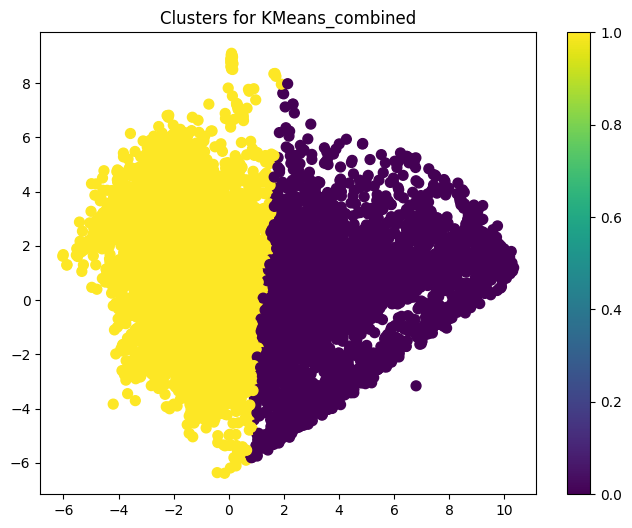

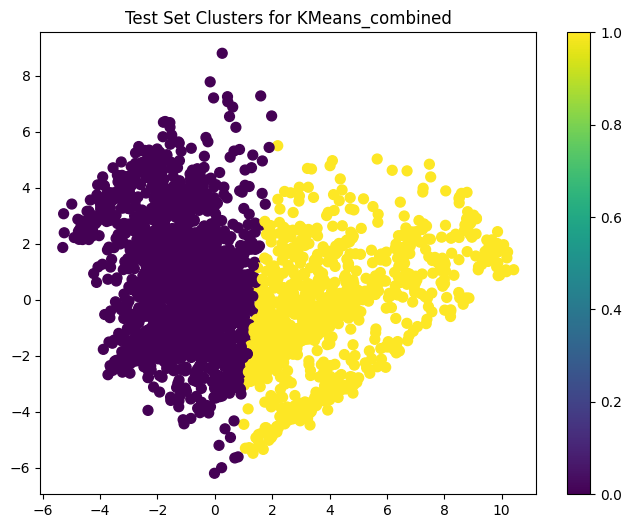

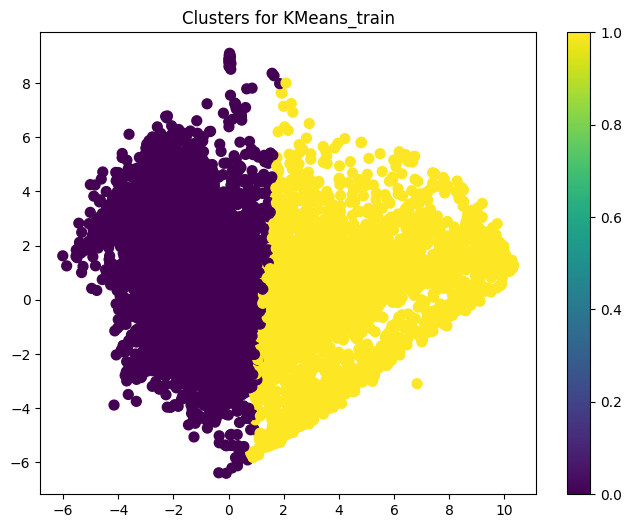

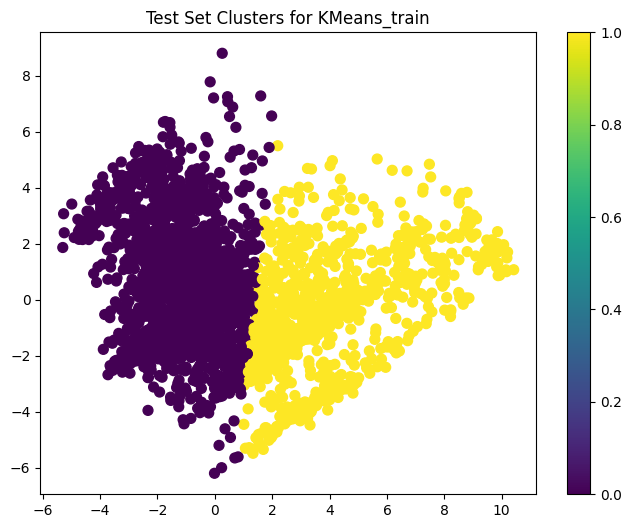

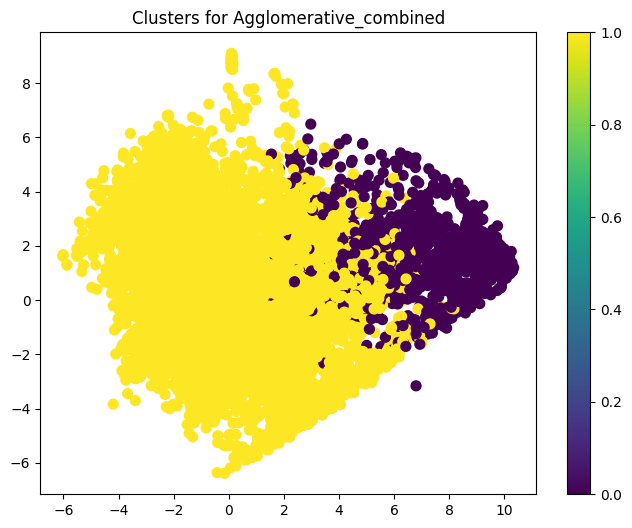

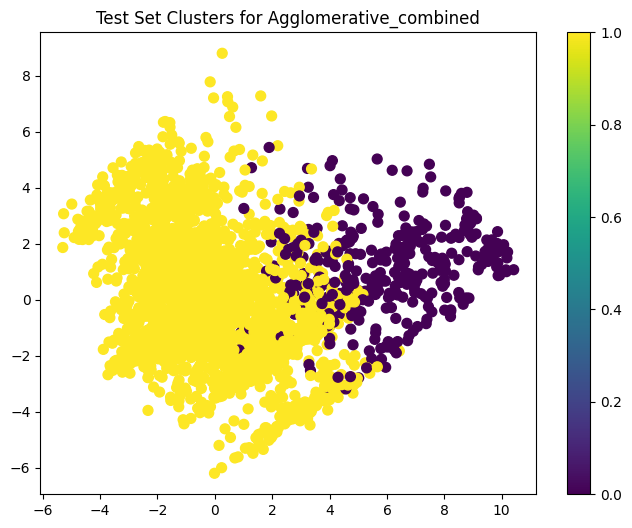

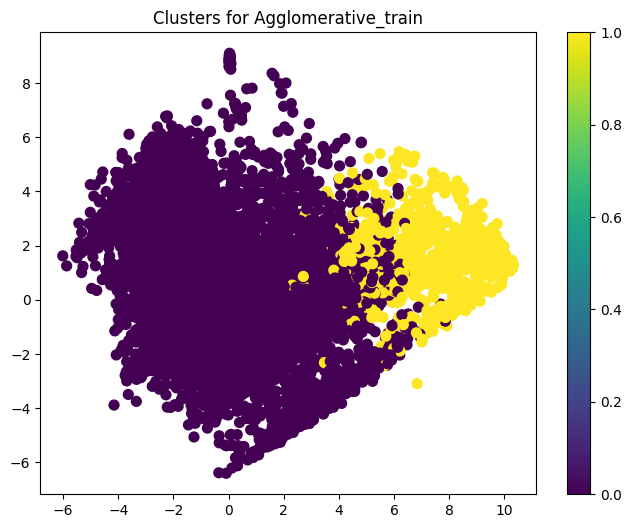

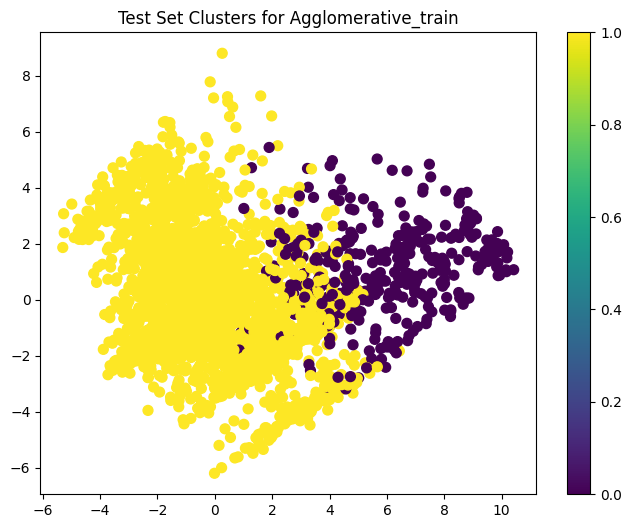

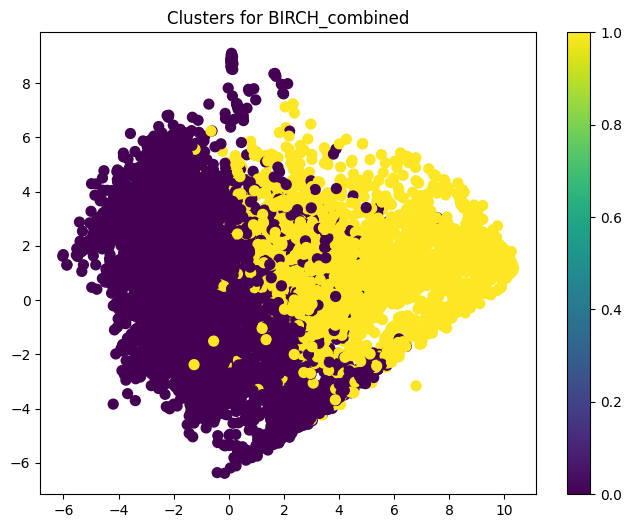

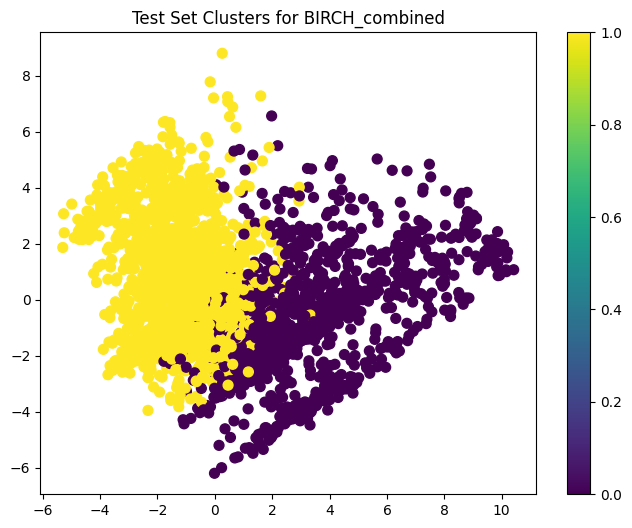

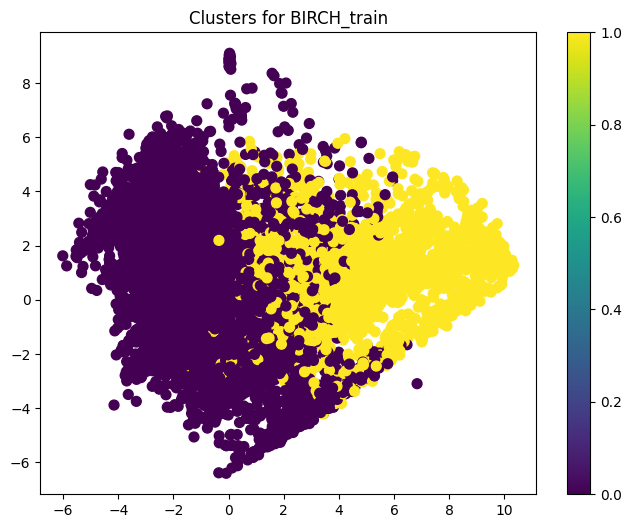

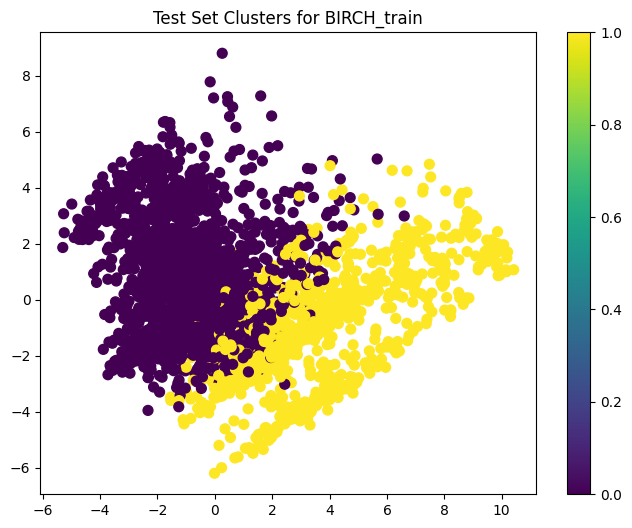

In [9]:
###Visualize the clusters using PCA
def plot_clusters(X, labels, title):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', s=50)
    plt.colorbar()
    plt.title(title)
    plt.show()

###Plot clusters for each best model
for name, model in best_models.items():
    data = X_train_val if 'combined' in name else train_features_scaled
    labels = model.fit_predict(data)
    plot_clusters(data, labels, f'Clusters for {name}')
    
    # Plot clusters for the test set
    test_labels_pred = model.fit_predict(test_features_scaled)
    plot_clusters(test_features_scaled, test_labels_pred, f'Test Set Clusters for {name}')

### Assessment of XGBoost, Random Forest, and Logistic Regression

To evaluate the performance of my models, I used three supervised learning algorithms: XGBoost, Random Forest, and Logistic Regression. Each of these methods has unique strengths, making them suitable for different types of data and tasks.

First, I optimized each model using hyperparameter tuning, which involves adjusting settings that control the learning process. I used grid search with cross-validation to find the best combination of hyperparameters for each model. For XGBoost, I tuned parameters like the number of trees, the depth of each tree, the learning rate, and the subsample ratio. XGBoost is known for its high performance and ability to handle complex data patterns thanks to its gradient boosting framework. For Random Forest, I adjusted the number of trees, the maximum depth of each tree, and the minimum number of samples required to split a node or be at a leaf. Random Forest combines multiple decision trees to improve accuracy and control overfitting. For Logistic Regression, I optimized the penalty type, regularization strength, solver type, and the number of iterations. Logistic Regression is a linear model that estimates the probability of a binary outcome. 

I evaluated each model using the accuracy score on the test set, providing an unbiased assessment of how well the model performs on new unseen data. Additionally, I looked at the classification reports for each model to understand their precision, recall, and F1-scores for different classes. 

Comparing these supervised methods with my clustering results provides a baseline to assess the value of labeled data. Clustering reveals natural groupings within the data while supervised learning enhances prediction accuracy using labeled outcomes. 


RandomForestClassifier Grid Search
Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; tot

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_esti

[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  

[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; 

[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time

[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total tim

[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total tim

[CV] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0

[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0

[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.7; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=10

[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.7; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=15, n_estima

[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1

[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0

[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.9; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.9; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, 

[CV] END learning_rate=0.1, max_depth=15, n_estimators=200, subsample=0.9; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=200, subsample=0.9; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=200, subsample=1.0; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=15, n_estimators=200, subsample=1.0; total time=   1.8s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=10, subsampl

[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=10, subsample=1.0; total t

[CV] END learning_rate=0.2, max_depth=10, n_estimators=10, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=10, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=10, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=10, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=10, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=50, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=50, subsample=0

[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.7; total time=   0.9s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=15, n_estimators=50, subsample=0

[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; tota

[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0

[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=10, n_estimators=200, 

[CV] END learning_rate=0.3, max_depth=15, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.7; total time=   1.5s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.7; total time=   1.8s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.7; total time=   1.6s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END learning_rate=0.3, max_depth=15, n_estimators=200, 

[CV] END .......C=0.01, max_iter=500, penalty=l2, solver=sag; total time=   0.2s
[CV] END .......C=0.01, max_iter=500, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.01, max_iter=500, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END C=0.01, max_iter=500, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END C=0.01, max_iter=500, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END C=0.01, max_iter=500, penalty=none, solver=newton-cg; total time=   0.2s
[CV] END C=0.01, max_iter=500, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END ...C=0.01, max_iter=500, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ...C=0.01, max_iter=500, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ...C=0.01, max_iter=500, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ...C=0.01, max_iter=500, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ...C=0.01, max_iter=500, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END .....C=0.01, m

[CV] END ......C=0.1, max_iter=500, penalty=none, solver=sag; total time=   0.2s
[CV] END ......C=0.1, max_iter=500, penalty=none, solver=sag; total time=   0.2s
[CV] END ......C=0.1, max_iter=500, penalty=none, solver=sag; total time=   0.2s
[CV] END ......C=0.1, max_iter=500, penalty=none, solver=sag; total time=   0.2s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END ........C=1, max_it

[CV] END .......C=10, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.2s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.2s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.2s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.2s
[CV] END .........C=10, max_iter=100, penalty=l2, solver=sag; total time=   0.2s
[CV] END .C=10, max_iter=100, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END .C=10, max_iter=100, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END .C=10, max_iter=100, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END .C=10, max_iter=100, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END .C=10, max_iter=100, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END .....C=10, max_iter

[CV] END ....C=100, max_iter=100, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ....C=100, max_iter=100, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ....C=100, max_iter=100, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ....C=100, max_iter=100, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ....C=100, max_iter=100, penalty=none, solver=lbfgs; total time=   1.0s
[CV] END ......C=100, max_iter=100, penalty=none, solver=sag; total time=   0.2s
[CV] END ......C=100, max_iter=100, penalty=none, solver=sag; total time=   0.2s
[CV] END ......C=100, max_iter=100, penalty=none, solver=sag; total time=   0.2s
[CV] END ......C=100, max_iter=100, penalty=none, solver=sag; total time=   0.2s
[CV] END ......C=100, max_iter=100, penalty=none, solver=sag; total time=   0.2s
[CV] END ..C=100, max_iter=200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=100, max_iter=200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=100, max_iter=2

[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=0.1, max_iter=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..C=0.1, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......C=0.1, max_iter=200, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=0.1, max_iter=200, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=0.1, max_i

[CV] END .......C=100, max_iter=200, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=100, max_iter=200, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=100, max_iter=200, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..C=100, max_iter=500, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, max_iter=500, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, max_iter=500, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, max_iter=500, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=100, max_iter=500, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=100, max_iter=500, penalty=l1, solver=saga; total time=   0.2s
[CV] END .......C=100, max_i

Best parameters found for Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'none', 'solver': 'newton-cg'}
Logistic Regression Accuracy on test data: 0.8202937249666221


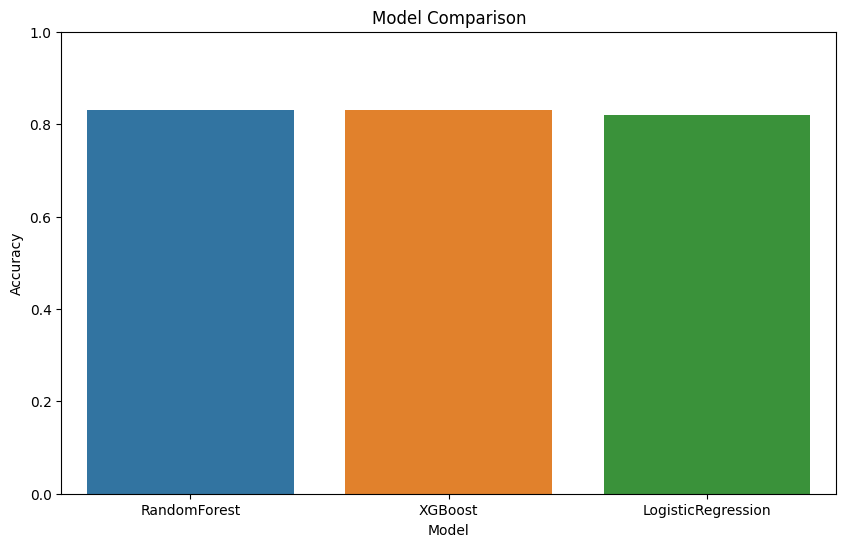

In [10]:
###Initialize lists to store results
model_names = []
model_accuracies = []

###RandomForestClassifier
print("RandomForestClassifier Grid Search")
rf_param_grid = {
    'n_estimators': [10,50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='accuracy', verbose=2)
rf_grid_search.fit(train_features_scaled, train_labels)

print("Best parameters found for RandomForest:", rf_grid_search.best_params_)
rf_best_model = rf_grid_search.best_estimator_

rf_test_predictions = rf_best_model.predict(test_features_scaled)
rf_test_accuracy = accuracy_score(test_labels, rf_test_predictions)
print("RandomForest Accuracy on test data:", rf_test_accuracy)

###Store results
model_names.append('RandomForest')
model_accuracies.append(rf_test_accuracy)

###XGBoost
print("\nXGBoost Grid Search")
xgb_param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

xgb = XGBClassifier(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy', verbose=2)
xgb_grid_search.fit(train_features_scaled, train_labels)

print("Best parameters found for XGBoost:", xgb_grid_search.best_params_)
xgb_best_model = xgb_grid_search.best_estimator_

xgb_test_predictions = xgb_best_model.predict(test_features_scaled)
xgb_test_accuracy = accuracy_score(test_labels, xgb_test_predictions)
print("XGBoost Accuracy on test data:", xgb_test_accuracy)

###Store results
model_names.append('XGBoost')
model_accuracies.append(xgb_test_accuracy)

###Logistic Regression
print("\nLogistic Regression Grid Search")
###Define parameter grid for Logistic Regression with compatible solvers and penalties
log_reg_param_grid = [
    {'penalty': ['l2', 'none'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 500]},
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 500]},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.5], 'max_iter': [100, 200, 500]}
]

log_reg = LogisticRegression(random_state=42, n_jobs=-1)
log_reg_grid_search = GridSearchCV(estimator=log_reg, param_grid=log_reg_param_grid, cv=5, scoring='accuracy', verbose=2)
log_reg_grid_search.fit(train_features_scaled, train_labels)

print("Best parameters found for Logistic Regression:", log_reg_grid_search.best_params_)
log_reg_best_model = log_reg_grid_search.best_estimator_

log_reg_test_predictions = log_reg_best_model.predict(test_features_scaled)
log_reg_test_accuracy = accuracy_score(test_labels, log_reg_test_predictions)
print("Logistic Regression Accuracy on test data:", log_reg_test_accuracy)

###Store results
model_names.append('LogisticRegression')
model_accuracies.append(log_reg_test_accuracy)

###Visualization
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': model_accuracies
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [11]:
###Calculate precision and recall for each model
rf_precision = precision_score(test_labels, rf_test_predictions)
rf_recall = recall_score(test_labels, rf_test_predictions)

xgb_precision = precision_score(test_labels, xgb_test_predictions)
xgb_recall = recall_score(test_labels, xgb_test_predictions)

log_reg_precision = precision_score(test_labels, log_reg_test_predictions)
log_reg_recall = recall_score(test_labels, log_reg_test_predictions)

###Print the precision and recall for each model
print(f"Random Forest Model - Precision: {rf_precision:.2f}, Recall: {rf_recall:.2f}")
print(f"XGBoost Model - Precision: {xgb_precision:.2f}, Recall: {xgb_recall:.2f}")
print(f"Logistic Regression Model - Precision: {log_reg_precision:.2f}, Recall: {log_reg_recall:.2f}")


Random Forest Model - Precision: 0.68, Recall: 0.38
XGBoost Model - Precision: 0.68, Recall: 0.38
Logistic Regression Model - Precision: 0.64, Recall: 0.33


### Analysis of Supervised Learning Results

The results of the models both with and without data transformations highlight the impact of feature scaling and transformations on model performance. The data transformation process involved applying log transformations to right-skewed features and power transformations to left-skewed features followed by scaling and removing outliers. This preprocessing step was intended to normalize the data distribution and test potential model improvement.  

For the RandomForest model, the best parameters with data transformation resulted in an accuracy of 0.8318, while without data transformation, the accuracy was 0.8084. This improvement suggests that the data transformation made the features more suitable for the model reducing variance and making the data more Gaussian-like which is beneficial for tree-based algorithms.

Similarly, for the XGBoost model, the best parameters with data transformation yielded an accuracy of 0.8315, compared to 0.8051 without transformation. XGBoost, being a gradient boosting framework, benefits from well-distributed data as it relies on the sequential addition of models to correct errors from previous models. 

For the Logistic Regression model, the best parameters with data transformation achieved an accuracy of 0.8224, whereas the accuracy without transformation was 0.7998. Logistic Regression, being a linear model, is highly sensitive to the distribution of the input features. The transformations applied likely made the features more linear and reduced multicollinearity leading to better performance.

Precision & Recall however tell a slighlty different story: 


| Model                   | Precision          | Recall             |
|-------------------------|--------------------|--------------------|
| **Random Forest**       | 0.68               | 0.38               |
| **XGBoost**             | 0.68               | 0.38               |
| **Logistic Regression** | 0.64               | 0.33               |



Low precision and recall with high accuracy in this case likely has to do with not addressing class imbalance.  Adding SMOTE analysis to the data set generates the following output: 


| Model                | Test Accuracy       | Precision          | Recall             |
|----------------------|---------------------|--------------------|--------------------|
| **XGBoost**          | 0.8315086782376502  | 0.85               | 0.87               |
| **Random Forest**    | 0.8317757009345794  | 0.85               | 0.85               |
| **Logistic Regression** | 0.822429906542056 | 0.74               | 0.62               |


Higher Accuracy, precision and recall across the board.  

### Overall Analysis Comparing Supervised vs. Unsupervised Approaches

In the end, supervised learning methods outperformed the unsupervised approaches for predicting credit card defaults. This is because supervised learning models are specifically designed to use labeled data to learn the relationship between input features and the target outcome whihc in this case was whether a client will default on their credit card payment. These models are trained to directly optimize for prediction accuracy which allows them to achieve higher performance and make better predictions on new data.

With unsupervised learning techniques like clustering, we don't use the target variable during training. Instead, they focus on finding natural groupings and patterns within the data without knowing what the actual outcomes are. While this can reveal interesting insights, it's not as effective for making precise predictions about a specific outcome.

In [12]:
'''
Data Transformation w/ SMOTE Best parameters found for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest Accuracy on test data: 0.8494971876597921

Data Transformation: Best parameters found for RandomForest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest Accuracy on test data: 0.8317757009345794

No Data Transformation Best parameters found for RandomForest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
RandomForest Accuracy on test data: 0.8084242578025882
'''

'''
Data Transformation with SMOTE Best parameters found for XGBoost: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Accuracy on test data: 0.8569967615476394

Data Transformation Best parameters found for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
XGBoost Accuracy on test data: 0.8315086782376502

No Data Transformation Best parameters found for XGBoost: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
XGBoost Accuracy on test data: 0.8051256026389241

'''

'''
Data Transformation with SMOTE Best parameters found for Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
Logistic Regression Accuracy on test data: 0.704789500596557

Data Transformation Best parameters found for Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Logistic Regression Accuracy on test data: 0.822429906542056

No Data Transformation Best parameters found for Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Logistic Regression Accuracy on test data: 0.7997970058360823
'''

"\nData Transformation with SMOTE Best parameters found for Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}\nLogistic Regression Accuracy on test data: 0.704789500596557\n\nData Transformation Best parameters found for Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}\nLogistic Regression Accuracy on test data: 0.822429906542056\n\nBest parameters found for Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}\nLogistic Regression Accuracy on test data: 0.7997970058360823\n"

Lastly, I add a feature importance analysis below to see which features most impacted model performance and we can see that PC2, PC13, and PC1 have the largest outsize impact on the model.  

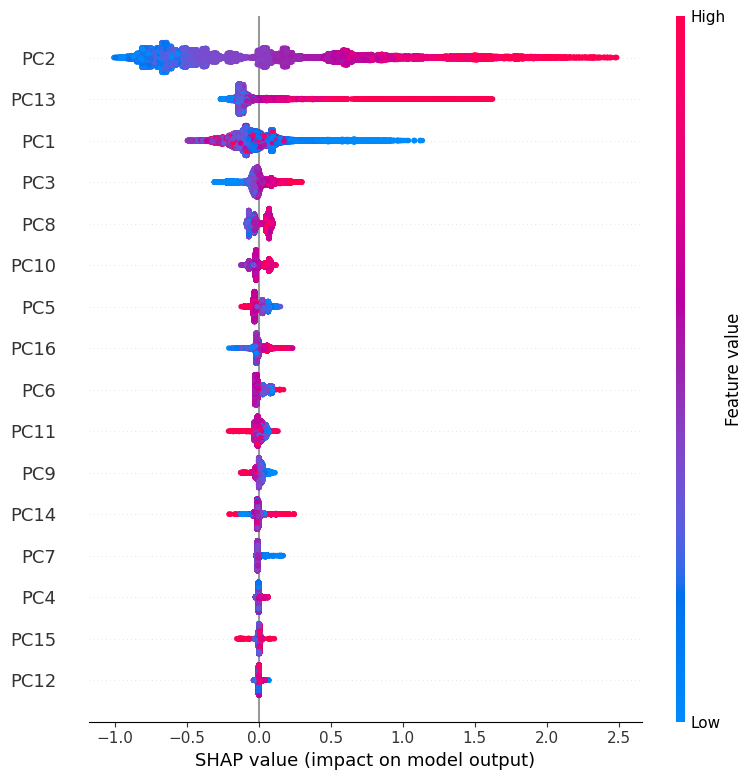

In [13]:
explainer = shap.Explainer(xgb_best_model, train_features_scaled)
shap_values = explainer(train_features_scaled)

###Plotting feature importance
shap.summary_plot(shap_values, train_features_scaled)
